In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource,HoverTool
from bokeh.io import show, output_notebook
from scipy.ndimage import gaussian_gradient_magnitude
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import seaborn as sns
from matplotlib_venn import venn2
import scipy as sp
import os

In [2]:
grammy_data_path = '../datasets/grammySongs_1999-2019.csv'
spotify_data_path = '../datasets/songAttributes_1999-2019.csv'
billboard_data_path = '../datasets/billboardHot100_1999-2019.csv'

In [4]:
spotify = pd.read_csv(spotify_data_path)
grammy = pd.read_csv(grammy_data_path)
billboard = pd.read_csv(billboard_data_path)

In [10]:
spotify.head()

,Unnamed: 0,Acousticness,Album,Artist,Danceability,Duration,Energy,Explicit,Instrumentalness,Liveness,Loudness,Mode,Name,Popularity,Speechiness,Tempo,TimeSignature,Valence
0,0,0.000728,Collective Soul (Deluxe Version),Collective Soul,0.520,234947,0.904,False,0.010300,0.0634,-5.030,1,Welcome All Again,35,0.0309,106.022,4,0.365
1,1,0.018200,Collective Soul (Deluxe Version),Collective Soul,0.581,239573,0.709,False,0.000664,0.1740,-4.909,1,Fuzzy,31,0.0282,120.027,4,0.408
2,2,0.000473,Collective Soul (Deluxe Version),Collective Soul,0.572,198400,0.918,False,0.000431,0.0977,-3.324,0,Dig,30,0.0559,144.061,4,0.370
3,3,0.000970,Collective Soul (Deluxe Version),Collective Soul,0.596,231453,0.661,False,0.000033,0.1130,-5.051,1,You,35,0.0254,111.975,4,0.183
4,4,0.000036,Collective Soul (Deluxe Version),Collective Soul,0.520,222520,0.808,False,0.000010,0.0800,-4.553,0,My Days,21,0.0318,92.721,4,0.666


In [5]:
len(spotify)


154931

In [6]:
len(grammy)


428

In [7]:
len(billboard)


97225

In [151]:
# put spotify into the same format
spotify['Artist'] = spotify['Artist'].str.strip("[]")
spotify['Artist'] = spotify['Artist'].str.replace("'", "").str.replace(" &", ",")
spotify.rename(columns = {'name':'Name'}, inplace = True)
spotify['Name'] = spotify['Name'].str.lower()
spotify['Artist'] = spotify['Artist'].str.lower()

# put grammy into the same format
grammy['Artist'] = grammy['Artist'].str.replace(" &", ",")
grammy['Name'] = grammy['Name'].str.lower()
grammy['Artist'] = grammy['Artist'].str.lower()

# put billboard into the same format
billboard.rename(columns = {'Artists':'Artist'}, inplace = True)
billboard['Artist'] = billboard['Artist'].str.replace(" &", ",")
billboard['Name'] = billboard['Name'].str.lower()
billboard['Artist'] = billboard['Artist'].str.lower()

In [152]:
# clean spotify dataset (in case it contains the same songs by the same artists)
songs = spotify.groupby(['Name', 'Artist'], as_index = False).agg({'Acousticness' : 'mean', 'Danceability' : 'mean', 'Duration' : 'mean', 'Energy' : 'mean', 'Explicit' : 'max', 'Instrumentalness' : 'mean',  'Liveness' : 'mean',  'Loudness' : 'mean',  'Mode' : 'max', 'Popularity' : 'sum', 'Speechiness' : 'mean', 'Tempo' : 'mean', 'Valence' : 'mean'})

# clean grammy songs, merge it with songs(spotify) to get more info, drop useless columns
gr = grammy.merge(songs, on = ['Name', 'Artist'])
gr = gr.drop(columns = 'Unnamed: 0').drop(columns = 'X')

# clean billboard
bb1 = billboard.groupby(['Name', 'Artist', 'Week', 'Weekly.rank'], as_index = False).agg({'Weeks.on.chart' : 'max', 'Peak.position' : 'min', 'Genre' : 'first', 'Date':'first'})
bb1 = bb1.merge(songs, on = ['Name', 'Artist'])
bb2 = bb1.groupby(['Name','Artist'], as_index = False).agg({'Weeks.on.chart' : 'max', 'Peak.position' : 'min'})
bb2 = bb2.dropna(subset = ['Peak.position', 'Weeks.on.chart'])
bb3 = bb1.groupby(['Name','Artist'], as_index = False).agg({'Acousticness' : 'mean', 'Danceability' : 'mean', 'Duration' : 'mean', 'Energy' : 'mean', 'Explicit' : 'max', 'Instrumentalness' : 'mean',  'Liveness' : 'mean',  'Loudness' : 'mean',  'Mode' : 'max', 'Speechiness' : 'mean', 'Tempo' : 'mean', 'Valence' : 'mean'})

# capitalize each word (reformatting)
songs['Name'] = songs['Name'].str.title()
songs['Artist'] = songs['Artist'].str.title()
gr['Name'] = gr['Name'].str.title()
gr['Artist'] = gr['Artist'].str.title()
bb1['Name'] = bb1['Name'].str.title()
bb1['Artist'] = bb1['Artist'].str.title()
bb2['Name'] = bb2['Name'].str.title()
bb2['Artist'] = bb2['Artist'].str.title()
bb3['Name'] = bb3['Name'].str.title()
bb3['Artist'] = bb3['Artist'].str.title()
bb3['Loudness'] = bb3['Loudness']/60 + 1
songs['Loudness'] = songs['Loudness']/60 + 1
gr['Loudness'] = gr['Loudness']/60 + 1

In [207]:
bb1

,Name,Artist,Week,Weekly.rank,Weeks.on.chart,Peak.position,Genre,Date,Acousticness,Danceability,...,Energy,Explicit,Instrumentalness,Liveness,Loudness,Mode,Popularity,Speechiness,Tempo,Valence
0,...Ready For It?,Taylor Swift,2017-09-23,4,NaN,NaN,"Electronic,Electro-Pop,Pop","September 3, 2017",0.05270,0.613,...,0.764,False,0.000000,0.1970,-6.509,1,70,0.1360,160.015,0.417
1,...Ready For It?,Taylor Swift,2017-09-30,21,2.0,4.0,"Electronic,Electro-Pop,Pop","September 3, 2017",0.05270,0.613,...,0.764,False,0.000000,0.1970,-6.509,1,70,0.1360,160.015,0.417
2,...Ready For It?,Taylor Swift,2017-10-07,34,3.0,4.0,"Electronic,Electro-Pop,Pop","September 3, 2017",0.05270,0.613,...,0.764,False,0.000000,0.1970,-6.509,1,70,0.1360,160.015,0.417
3,...Ready For It?,Taylor Swift,2017-10-14,39,4.0,4.0,"Electronic,Electro-Pop,Pop","September 3, 2017",0.05270,0.613,...,0.764,False,0.000000,0.1970,-6.509,1,70,0.1360,160.015,0.417
4,...Ready For It?,Taylor Swift,2017-10-21,47,5.0,4.0,"Electronic,Electro-Pop,Pop","September 3, 2017",0.05270,0.613,...,0.764,False,0.000000,0.1970,-6.509,1,70,0.1360,160.015,0.417
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52273,Youth Of The Nation,P.O.D.,2002-06-04,89,18.0,28.0,"Alternative Rock,Alternative Metal,Rap Rock,Ro...","December 25, 2001",0.00834,0.563,...,0.860,False,0.010600,0.3900,-7.533,1,72,0.0621,97.867,0.517
52274,Youth Of The Nation,P.O.D.,2002-06-11,92,19.0,28.0,"Alternative Rock,Alternative Metal,Rap Rock,Ro...","December 25, 2001",0.00834,0.563,...,0.860,False,0.010600,0.3900,-7.533,1,72,0.0621,97.867,0.517
52275,Yuck!,2 Chainz,2012-08-31,80,NaN,NaN,Rap,"August 14, 2012",0.65200,0.600,...,0.882,True,0.000236,0.1460,-4.385,0,35,0.2920,149.966,0.423
52276,Zero,Chris Brown,2016-01-08,80,NaN,NaN,"Funk,Disco,R&;B","September 18, 2015",0.05170,0.731,...,0.818,True,0.000000,0.0743,-4.564,0,57,0.0638,120.993,0.812


The venn diagram shows the intersection of popular and award-winning songs in the simplest and most straightforward way. As shown by the venn diagram, 109 out of 136 songs that got the Grammy Award (we count the songs that win multiple awards as one song) have appeared on the Billboard as some time.

# 1. a

In [29]:
stacked_genres = bb1['Genre'].str.split(',', expand=True).stack()

In [33]:
genre_counts = stacked_genres.value_counts()
genre_counts.head(10)

Pop                   20216
Rock                  17437
Country               13321
Rap                   12457
R&;B                  10013
Pop-Rock               5537
Alternative Rock       4618
Adult Alternative      2594
Soul                   2246
Adult Contemporary     2223
dtype: int64

In [214]:
bb1.Genre.value_counts().sort_values(ascending=False).head(15)

Country                  6203
Country,Rock             5283
Rap                      4160
Pop                      3751
Rock                     2205
R&;B                     1674
R&;B,Rap                 1303
R&;B,Pop                 1180
Pop,R&;B                  504
Alternative Rock,Rock     501
Pop,Rap                   427
Pop-Rock,Pop,Rock         404
Dance-Pop,Pop             338
Soul,R&;B                 336
Pop,Rock                  271
Name: Genre, dtype: int64

In [108]:
top_genres = list(bb1.Genre.value_counts().sort_values(ascending=False).head(15).keys())

In [109]:
top_genres

['Country',
 'Country,Rock',
 'Rap',
 'Pop',
 'Rock',
 'R&;B',
 'R&;B,Rap',
 'R&;B,Pop',
 'Pop,R&;B',
 'Alternative Rock,Rock',
 'Pop,Rap',
 'Pop-Rock,Pop,Rock',
 'Dance-Pop,Pop',
 'Soul,R&;B',
 'Pop,Rock']

In [110]:
filtered_df = bb1[bb1['Genre'].apply(lambda x: any(genre==x for genre in top_genres))]

In [111]:
filtered_df = filtered_df[filtered_df.iloc[:,:2].duplicated()==False]

In [112]:
filtered_df

,Name,Artist,Week,Weekly.rank,Weeks.on.chart,Peak.position,Genre,Date,Acousticness,Danceability,...,Energy,Explicit,Instrumentalness,Liveness,Loudness,Mode,Popularity,Speechiness,Tempo,Valence
19,1 Thing,Amerie,2005-02-09,100,NaN,NaN,"Pop,R&;B","January 5, 2005",0.115667,0.622667,...,0.962333,False,0.000065,0.034133,-3.452,0,6,0.308667,127.6710,0.858667
62,100 Grandkids,Mac Miller,2015-08-28,100,NaN,NaN,Rap,"August 7, 2015",0.371000,0.735000,...,0.749000,True,0.000000,0.470000,-3.766,0,65,0.087400,93.7180,0.373000
78,17 Again,Brantley Gilbert,2014-05-23,90,NaN,NaN,"Country,Rock","May 19, 2014",0.010700,0.429000,...,0.871000,False,0.000009,0.367000,-4.890,1,12,0.034700,173.9180,0.710000
79,19 Somethin',Mark Wills,2002-11-19,69,NaN,NaN,Country,"September 23, 2002",0.100000,0.360000,...,0.710000,False,0.000004,0.884000,-12.524,1,29,0.060600,184.0840,0.523000
112,1942 Flows,Meek Mill,2017-08-12,83,NaN,NaN,Rap,"July 21, 2017",0.051500,0.630000,...,0.628000,True,0.000000,0.091000,-4.016,1,51,0.327000,121.3070,0.266000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52205,Your Love,Nicki Minaj,2010-06-17,51,NaN,NaN,"Pop,Rap","June 1, 2010",0.001980,0.458500,...,0.514000,True,0.005935,0.408500,-10.202,1,45,0.299500,156.7845,0.196000
52225,Your Man,Josh Turner,2005-12-21,96,NaN,NaN,"Country,Rock","January 24, 2006",0.331000,0.742000,...,0.638000,False,0.000221,0.058400,-4.332,1,73,0.023900,100.5040,0.748000
52245,Your Side Of The Bed,Little Big Town,2013-08-30,96,NaN,NaN,"Country,Rock","April 8, 2013",0.676000,0.610000,...,0.383000,False,0.000000,0.094900,-7.543,1,48,0.032200,137.7660,0.164000
52246,Yours If You Want It,Rascal Flatts,2017-06-10,76,NaN,NaN,Country,"January 6, 2017",0.010200,0.544000,...,0.903000,False,0.000000,0.108000,-3.151,1,35,0.053500,113.0120,0.408000


In [113]:
fig = px.box(filtered_df, x='Genre', y='Danceability')

In [114]:
fig

In [115]:
fig = px.box(filtered_df, x='Genre', y='Acousticness')
fig

In [116]:
fig = px.box(filtered_df, x='Genre', y='Instrumentalness')
fig

In [117]:
fig = px.box(filtered_df, x='Genre', y='Valence')
fig

In [118]:
fig = px.box(filtered_df, x='Genre', y='Speechiness')
fig

In [119]:
fig = px.box(filtered_df, x='Genre', y='Energy')
fig

In [120]:
# repeat for all song attributes

# 2

In [121]:
gr

,GrammyAward,GrammyYear,Genre,Name,Artist,Acousticness,Danceability,Duration,Energy,Explicit,Instrumentalness,Liveness,Loudness,Mode,Popularity,Speechiness,Tempo,Valence
0,Best Rock Performance,2018,Rock,When Bad Does Good,Chris Cornell,0.039000,0.142,265973.0,0.6570,False,0.000000,0.3190,0.903883,1,51,0.04230,179.1190,0.0377
1,Best Rap Song,2018,Rap,God'S Plan,Drake,0.033200,0.754,198973.0,0.4490,True,0.000083,0.5520,0.846483,1,86,0.10900,77.1690,0.3570
2,Best American Roots Performance,2018,American Roots Music,The Joke,Brandi Carlile,0.327000,0.236,279373.0,0.5780,False,0.000150,0.2060,0.908717,1,62,0.04040,75.3670,0.2270
3,Best American Roots Song,2018,American Roots Music,The Joke,Brandi Carlile,0.327000,0.236,279373.0,0.5780,False,0.000150,0.2060,0.908717,1,62,0.04040,75.3670,0.2270
4,Record Of The Year,2017,General,24K Magic,Bruno Mars,0.034000,0.818,225983.0,0.8030,False,0.000000,0.1530,0.928633,1,79,0.07970,106.9700,0.6320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,Best Male Rock Vocal Performance,1999,Rock,American Woman,Lenny Kravitz,0.025800,0.678,263133.5,0.6895,False,0.000000,0.0756,0.867825,1,79,0.08025,83.9825,0.5735
164,Best Hard Rock Performance,1999,Rock,Whiskey In The Jar,Metallica,0.000006,0.518,304793.0,0.9720,False,0.000803,0.1865,0.938283,1,133,0.04215,132.9770,0.5290
165,Best Rock Song,1999,Rock,Scar Tissue,Red Hot Chili Peppers,0.077900,0.595,215907.0,0.7170,False,0.002740,0.1080,0.919950,1,77,0.02950,88.9690,0.5470
166,Best Female R&B Vocal Performance,1999,R&B,It'S Not Right But It'S Okay,Whitney Houston,0.162000,0.806,292400.0,0.8020,False,0.000885,0.0698,0.882067,1,66,0.10200,127.9310,0.5290


In [200]:
# Count the occurrences of each genre
genre_counts = gr['Genre'].value_counts()

In [201]:
genre_counts

Pop                                    37
Rock                                   35
Country                                31
General                                20
R&B                                    20
Rap                                    17
Dance/Electronic Music                  5
American Roots Music                    2
Gospel/Contemporary Christian Music     1
Name: Genre, dtype: int64

In [202]:
data = {
    'Genre': list(genre_counts.keys()),
    'Count': list(genre_counts.values)
}

In [203]:
data

{'Genre': ['Pop',
  'Rock',
  'Country',
  'General',
  'R&B',
  'Rap',
  'Dance/Electronic Music',
  'American Roots Music',
  'Gospel/Contemporary Christian Music'],
 'Count': [37, 35, 31, 20, 20, 17, 5, 2, 1]}

In [204]:
genre_counts = pd.DataFrame(data)

genre_counts.loc[genre_counts['Genre'].isin(['Dance/Electronic Music', 'American Roots Music', 'Gospel/Contemporary Christian Music']), 'Genre'] = 'Other'

# Sum the counts for each genre
genre_counts = genre_counts.groupby('Genre')['Count'].sum().reset_index()

In [205]:
genre_counts

,Genre,Count
0,Country,31
1,General,20
2,Other,8
3,Pop,37
4,R&B,20
5,Rap,17
6,Rock,35


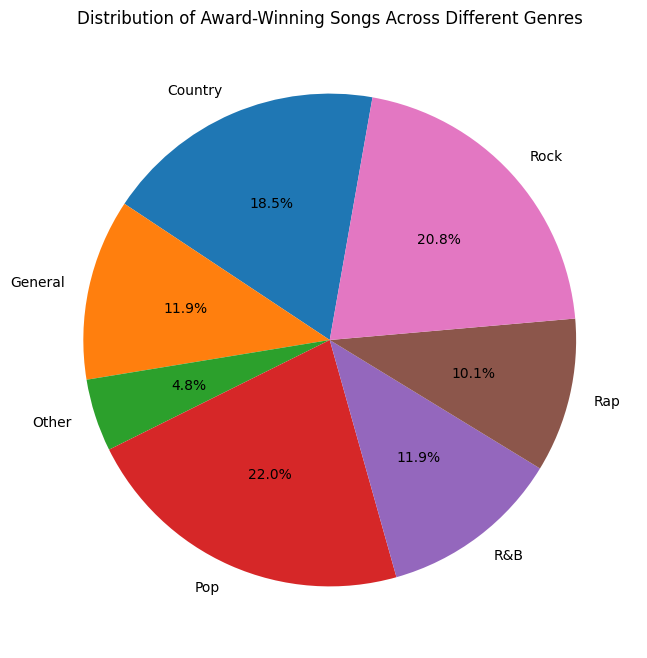

In [206]:
# Plotting a pie chart
plt.figure(figsize=(8, 8))
plt.pie(genre_counts['Count'], labels=genre_counts['Genre'], autopct='%1.1f%%', startangle=80)
plt.title('Distribution of Award-Winning Songs Across Different Genres')
plt.show()

# 6

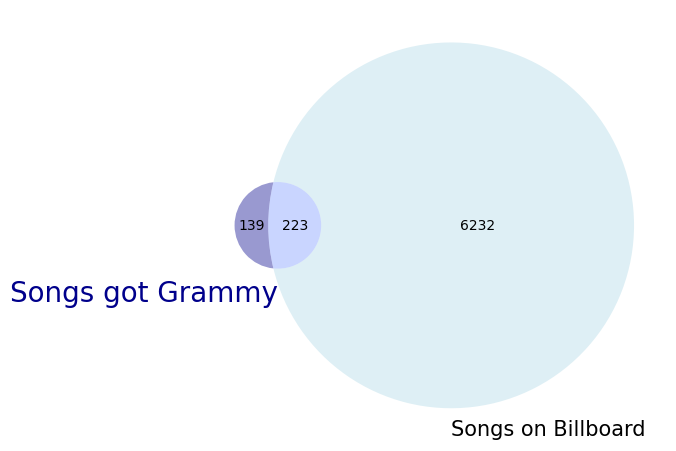

In [215]:
plt.figure(figsize=(6,6))
v = venn2([set(grammy['Name']), set(billboard['Name'])], 
          set_labels = ('Songs got Grammy', 'Songs on Billboard'), 
          set_colors=('darkblue', 'lightblue'), 
          )
v.get_label_by_id('A').set_size(20)
v.get_label_by_id('A').set_color('darkblue')
v.get_label_by_id('B').set_size(15)
v.get_label_by_id('A').set_color('darkblue')

In [211]:
gr['Name'] 

0                When Bad Does Good
1                        God'S Plan
2                          The Joke
3                          The Joke
4                         24K Magic
                   ...             
163                  American Woman
164              Whiskey In The Jar
165                     Scar Tissue
166    It'S Not Right But It'S Okay
167                      My Name Is
Name: Name, Length: 168, dtype: object

In [212]:
bb1['Name']

0           ...Ready For It?
1           ...Ready For It?
2           ...Ready For It?
3           ...Ready For It?
4           ...Ready For It?
                ...         
52273    Youth Of The Nation
52274    Youth Of The Nation
52275                  Yuck!
52276                   Zero
52277                   Zero
Name: Name, Length: 52278, dtype: object